# Assignment 2 Stochastic Simulation - Discrete Event Simulation 

In this assignment we will use the following notation:
- $\lambda$ - the arrival rate into the system.
- $\mu$ - the capacity of eaach of $\textit{n}$ equal servers.
- $\rho$ - the system load. In a single server system, it will be 
$\rho = \frac{\lambda}{\mu}$. In a multi-server system (one queue with $\textit{n}$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n \mu}$

The mean waiting time for an M/M/1 queuing system is defined by:

$$
E(W) = E(s) - \frac{1}{\mu} = \frac{\frac{\rho}{\mu}}{1 - \rho}
$$


The mean waiting time for an M/M/n queuing system is defined by:

$$
E(W) = \Pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{n \mu}
$$

where \( n \) is defined as the number of servers that are available.

In the case of multiple servers, the probability that all servers are full has to be taken into account. 
This is defined as:

$$
\Pi_W = \rho_n + \rho_{n+1} + \rho_{n+2} + \cdots = \frac{\rho_{c}}{1 - \rho}
$$


In [19]:
import numpy
import simpy
from random import seed
from scipy.stats import t
from scipy.stats import ttest_ind
import random
import statistics
import matplotlib.pyplot as plt

In [76]:
number_of_servers = [1,2,4]

def simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, random_seed):
    random.seed(random_seed)

    waitingTimes = []
    serviceTimes = []
    interarrivalTimes = []
    queue_lengths = []
    timestamps = []

    def generator(env, interval, server):  # customer generator with interarrival times.
        """generator generates customers randomly"""
        while True:
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time=random.expovariate(1.0/mean_service_time))
            env.process(c)
            t = random.expovariate(1.0/ interval)
            interarrivalTimes.append(t)
            yield env.timeout(t)  # adds time to the counter, does not delete from the memory

    def customer(env, name, server, service_time):
        # customer arrives to the system, waits and leaves
        arrive = env.now
        #print('%7.4f : Arrival time of %s' % (arrive, name))
        with server.request() as req:
            results = yield req | env.timeout(arrive)
            
            if req in results:
                servertime = service_time
                yield env.timeout(servertime)
                serviceTimes.append(servertime)
            else:
                waiting_time = env.now - arrive
                waitingTimes.append(waiting_time)
       
    def monitor(env, server):
        while True:
            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(1)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n)  # capacity changes the number of generators in the system.
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)
    #interarrivalTimes.append(interarrival)

    average_interarrival = statistics.mean(interarrivalTimes)
    average_waitingTime = statistics.mean(waitingTimes) if waitingTimes else 0
    average_serviceTime = statistics.mean(serviceTimes)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waitingTime": average_waitingTime,
        "average_serviceTime": average_serviceTime,
        "queue_lengths" : queue_lengths,
        "timestamps" : timestamps
    }

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = numpy.mean(data)
    std_err = numpy.std(data, ddof=1) / numpy.sqrt(n)
    t_value = t.ppf((1+ confidence)/2, df=n-1)
    return mean, mean - t_value * std_err, mean + t_value * std_err  

system_load = 0.95
mean_service_time = 4
simulations = 50
servers = [1,2,4]
simulation_time = 2000

random.seed(42)

service_rate = 1/mean_service_time
mean_interarrival_by_n = {n: 1 / (n*system_load * service_rate) for n in servers}

results = {1: [], 2: [], 4: []}
queue_length = {n: [] for n in servers}
time_data = {n: [] for n in servers}

for n in servers:
    mean_interarrival = mean_interarrival_by_n[n]
    print(f"Mean interarrival times by n: {mean_interarrival_by_n}")
    for _ in range(simulations):
        random_seed = random.randint(0,10000)
        result = simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, random.randint(0, 10000))
        results[n].append(result['average_waitingTime'])
        queue_length[n].append(result['queue_lengths'])
        time_data[n].append(result['timestamps'])
        # print(f"Server {n}, Simulation {_}, Average Waiting Time: {result['average_waitingTime']}")
        # print(f"Results[{n}]: {results[n]}")


print("\nSimulation results for n = 1,2 and 4:")
# Output results with confidence intervals
print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals:")
for n in results:
    mean, ci_lower, ci_upper = confidence_interval(results[n]) 
    print(
        f"Servers: {n}, "
        f"Mean Waiting Time: {mean:.4f}, "
        f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
    )



Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}
Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}
Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}

Simulation results for n = 1,2 and 4:

Simulation results for n=1, 2, and 4 with Confidence Intervals:
Servers: 1, Mean Waiting Time: 5.1408, 95% CI: (2.6993, 7.5823)
Servers: 2, Mean Waiting Time: 1.9810, 95% CI: (0.6067, 3.3553)
Servers: 4, Mean Waiting Time: 0.2421, 95% CI: (0.0470, 0.4372)


In [77]:
t_stat_1, p_value_1 = ttest_ind(results[1], results[2], equal_var=False)
print(f"T-statistic: {t_stat_1:.4f}, P-value: {p_value_1:.4f}")

if p_value_1 < 0.05:
    print("Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.")
else:
    print("Result is not statistically significant and we fail to reject H0")

t_stat_2, p_value_2 = ttest_ind(results[2], results[4], equal_var=False)
print(f"T-statistic: {t_stat_1:.4f}, P-value: {p_value_1:.4f}")

if p_value_2 < 0.05:
    print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected")
else:
    print("Result is not statistically significant and we cannot reject H0")

T-statistic: 2.2664, P-value: 0.0262
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 2.2664, P-value: 0.0262
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected


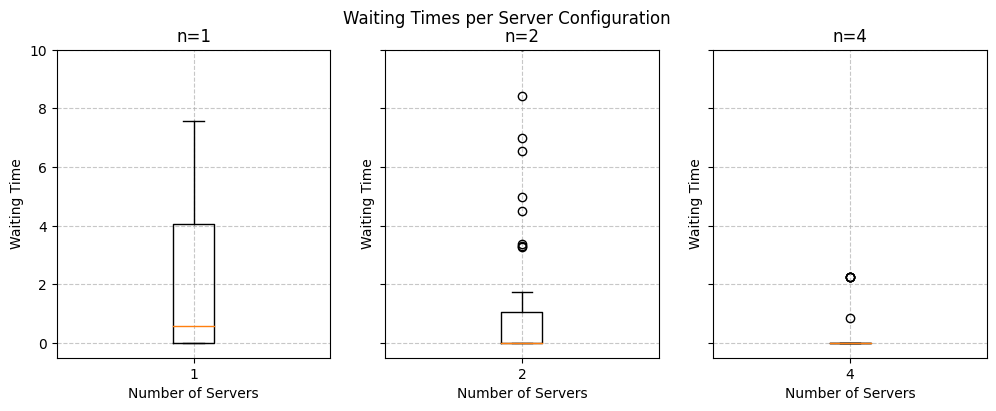

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, n in enumerate([1, 2, 4]):
    axes[i].boxplot(results[n], vert=True, labels=[n])
    axes[i].set_title(f"n={n}")
    axes[i].set_xlabel("Number of Servers")
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].set_ylim(-0.5,10)

    axes[i].set_ylabel("Waiting Time")
plt.suptitle("Waiting Times per Server Configuration")
plt.show()


In [89]:
# Compute average queue length and confidence intervals for each time step
import numpy as np

plot_data = {}
for n in servers:
    # Align data to the same length (truncate longer runs to the shortest run time)
    min_length = min(len(run) for run in queue_length[n])
    aligned_data = [run[:min_length] for run in queue_length[n]]
    timestamps = time_data[n][0][:min_length]  # Use timestamps from the first simulation

    # Compute averages and confidence intervals
    averages = np.mean(aligned_data, axis=0)
    print(averages)
    ci_lower = averages - 1.96 * np.std(aligned_data, axis=0) / np.sqrt(len(aligned_data))
    ci_upper = averages + 1.96 * np.std(aligned_data, axis=0) / np.sqrt(len(aligned_data))

    #averages, ci_lower, ci_upper = confidence_interval(results[n]) 
    plot_data[n] = {
        "timestamps": timestamps,
        "averages": averages,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }


[ 0.    0.08  0.2  ... 15.36 15.3  15.28]
[ 0.    0.04  0.16 ... 14.5  14.6  14.48]
[ 0.    0.02  0.04 ... 17.72 17.74 17.96]


ValueError: x and y must have same first dimension, but have shapes (2000,) and (1,)

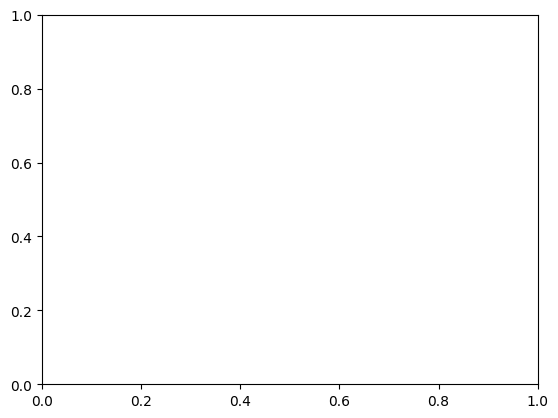

In [88]:
import matplotlib.pyplot as plt

# Plot queue lengths over time
for n in servers:
    timestamps = plot_data[n]["timestamps"]
    averages = plot_data[n]["averages"]
    ci_lower = plot_data[n]["ci_lower"]
    ci_upper = plot_data[n]["ci_upper"]

    plt.plot(timestamps, averages, label=f'n={n}')
    plt.fill_between(timestamps, ci_lower, ci_upper, alpha=0.2)

plt.title("Average Queue Length Over Time")
plt.xlabel("Time")
plt.ylabel("Average Queue Length")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
